In [1]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/Keres Projects/Date Format NN')

In [2]:
!pip install faker

In [3]:
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, Input, LSTM, RepeatVector, TimeDistributed, Lambda, Embedding
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model, Sequential
import keras.backend as K
import numpy as np


from nmt_util import *
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 10614.94it/s]


In [5]:
dataset[10:30]

[('sunday june 2 2002', '2002-06-02'),
 ('monday june 1 1987', '1987-06-01'),
 ('11 jan 2002', '2002-01-11'),
 ('saturday december 16 2006', '2006-12-16'),
 ('12 october 1984', '1984-10-12'),
 ('19 october 1982', '1982-10-19'),
 ('wednesday june 26 2002', '2002-06-26'),
 ('3 02 75', '1975-02-03'),
 ('21 july 2022', '2022-07-21'),
 ('tuesday may 3 2022', '2022-05-03'),
 ('monday april 18 2005', '2005-04-18'),
 ('09.07.96', '1996-07-09'),
 ('22.05.20', '2020-05-22'),
 ('september 4 1994', '1994-09-04'),
 ('23 dec 1974', '1974-12-23'),
 ('18.10.10', '2010-10-18'),
 ('15 apr 2013', '2013-04-15'),
 ('20 feb 1975', '1975-02-20'),
 ('7 jan 2019', '2019-01-07'),
 ('friday august 16 1996', '1996-08-16')]

In [6]:
X, Y = zip(*dataset)

#Preprocess The Data
In this step we will remove ny unwanted chars, like ','. Then convert all chrs to a lower case, after and finaly map each char to a code (number from 0 to 36).

In [7]:
# convert to lower case and remove any unwanted chars
X = [x.lower().replace(',', '') for x in X]
Y = [y.lower().replace(',', '') for y in Y]

In [8]:
X_proc = [[human_vocab.get(c) for c in string] for string in X]
Y_proc = [[machine_vocab.get(c) for c in string] for string in Y]

In [9]:
# map Y_proc to a one hot
Y_proc_oh = [to_categorical(example, num_classes=len(machine_vocab)) for example in Y_proc]

In [10]:
print(X_proc[10])
print(Y_proc[10])

[29, 31, 25, 16, 13, 34, 0, 22, 31, 25, 17, 0, 5, 0, 5, 3, 3, 5]
[3, 1, 1, 3, 0, 1, 7, 0, 1, 3]


In [11]:
# for each X, pad the remaining char with 'pad' from human_vocab until the Tx size = 30
Tx = 30
X_proc = [np.pad(example, (0, Tx - len(example)), 'constant', constant_values=36) for example in X_proc]
X_proc[10]

array([29, 31, 25, 16, 13, 34,  0, 22, 31, 25, 17,  0,  5,  0,  5,  3,  3,
        5, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36])

In [12]:
#split for test and training
X_train, X_test, Y_train, Y_test = train_test_split(X_proc, Y_proc_oh, test_size=0.2)

#Build The Model

## Model 1
In this model we will use the following archeticture:
- Embedding layer
  - To convert the input characters into dense vectors of fixed size, capturing semantic relationships between them.

- LSTM encoder
  - To process the input sequence and encode the context
- RepeatVector Layer
  - To repeat the encoded context vector to create a sequence for the next LSTM model to process.
- LSTM decoder
  - It takes the repeated context and predicts the output sequence, one step at a time, by using the information from previous steps to help make better predictions.
- TimeDistributed for Dense Layers
  - To apply the same Dense layer to each time step of the sequence, predicting the probability distribution of the output at each time step.



In [27]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(human_vocab), output_dim=64, input_shape=(Tx,)))
model_1.add(LSTM(units=128, return_sequences=False))
model_1.add(RepeatVector(10))
model_1.add(LSTM(units=128, return_sequences=True))
model_1.add(TimeDistributed(Dense(units = len(machine_vocab), activation='softmax')))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 30, 64)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_9 (RepeatVector)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 11)              │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,187 (914.79 KB)

 Trainable params: 234,187 (914.79 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_1 = model_1.fit(np.array(X_train), np.array(Y_train), epochs=20, batch_size=32)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.3015 - loss: 1.9341
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.4759 - loss: 1.1949
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.4725 - loss: 1.1891
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.4717 - loss: 1.1857
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.4956 - loss: 1.1583
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6394 - loss: 0.8818
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.7275 - loss: 0.6650
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.8083 - loss: 0.4701
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9025 - loss: 0.2871
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9519 - loss: 0.1729
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9822 - loss: 0.0974
Epoch 12/20
250/250 ━━━━━━━━━━

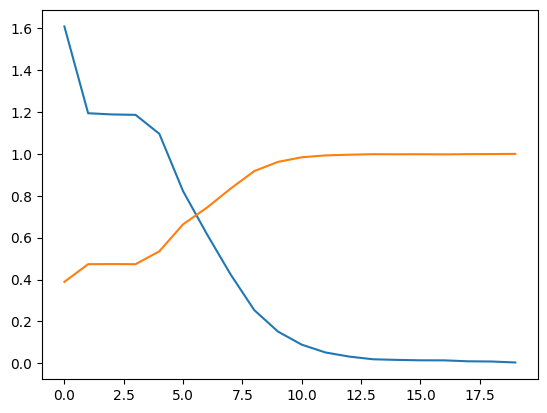

In [29]:
#plot the result
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['accuracy'])

## Model 2
Train this model using only 1 LSTM layer.

We know that the LSTM layer is capturing contex on a sequence ('tuesday march 1 1994') for example, then why adding another? We know that a second LSTM layer will capture the context for the context vector created by the first LSTM layer, but is it necessary for this task?

In [23]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(human_vocab), output_dim=64, input_shape=(Tx,)))
model_2.add(LSTM(units=128, return_sequences=False))
model_2.add(RepeatVector(10))
model_2.add(TimeDistributed(Dense(units = len(machine_vocab), activation='softmax')))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 30, 64)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_7 (RepeatVector)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 11)              │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,603 (400.79 KB)

 Trainable params: 102,603 (400.79 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_2 = model_2.fit(np.array(X_train), np.array(Y_train), epochs=20, batch_size=32)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2093 - loss: 2.1342
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.2571 - loss: 1.9911
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.2634 - loss: 1.8808
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.2693 - loss: 1.7819
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.2733 - loss: 1.7536
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2746 - loss: 1.7378
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.2750 - loss: 1.7335
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2738 - loss: 1.7339
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.2763 - loss: 1.7239
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.2746 - loss: 1.7263
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.2747 - loss: 1.7409
Epoch 12/20
250/250 ━━━━━━━━━━━

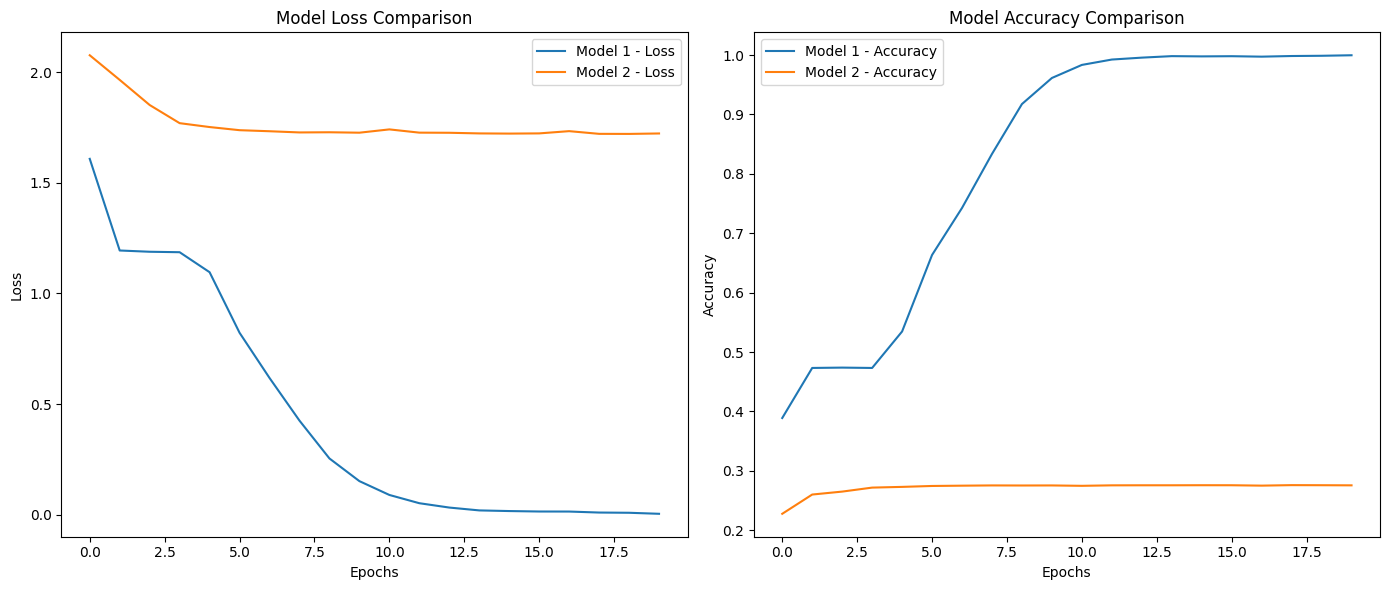

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss for both models
ax1.plot(history_1.history['loss'], label='Model 1 - Loss')
ax1.plot(history_2.history['loss'], label='Model 2 - Loss')
ax1.set_title('Model Loss Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy for both models
ax2.plot(history_1.history['accuracy'], label='Model 1 - Accuracy')
ax2.plot(history_2.history['accuracy'], label='Model 2 - Accuracy')
ax2.set_title('Model Accuracy Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()




**Notice** the big difference in performance between building the model using only 1 LSTM and between using 2. The 2 LSTM layer model were able to capture more context, thus leading to better performance and accurecy.

## Model 3
What is a bidirectional LSTM? If we build the model using only the bidirectional layer, what would be the performance will be compared to the previous two models?

In [40]:
model_3 = Sequential()
model_3.add(Embedding(input_dim=len(human_vocab), output_dim=64, input_shape=(Tx,)))
model_3.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_3.add(RepeatVector(10))
model_3.add(TimeDistributed(Dense(units = len(machine_vocab), activation='softmax')))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 30, 64)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_11 (RepeatVector)      │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 10, 11)              │           2,827 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,827 (792.29 KB)

 Trainable params: 202,827 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history_3 = model_3.fit(np.array(X_train), np.array(Y_train), epochs=20, batch_size=32)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.2220 - loss: 2.1104
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.2675 - loss: 1.8568
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.2716 - loss: 1.7677
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.2731 - loss: 1.7437
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.2753 - loss: 1.7335
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.2759 - loss: 1.7277
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.2745 - loss: 1.7296
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.2742 - loss: 1.7284
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.2752 - loss: 1.7248
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - accuracy: 0.2752 - loss: 1.7201
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.2749 - loss: 1.7267
Epoch 12/20
250/250 ━━━━━━━

The Bidirectional LSTM is like stacking two LSTM layers: one for the forward pass, the other is for the backward pass. Meaning that at this stage the model will take the input (left to right) and it will pass it through the forward LSTM, then on the same time, it will take the same vector and pass it backward to the second LSTM layer. This will give at each timestep a better representtion of the (embedded char in this example) not relying only on past sequence, but also on future sequences.

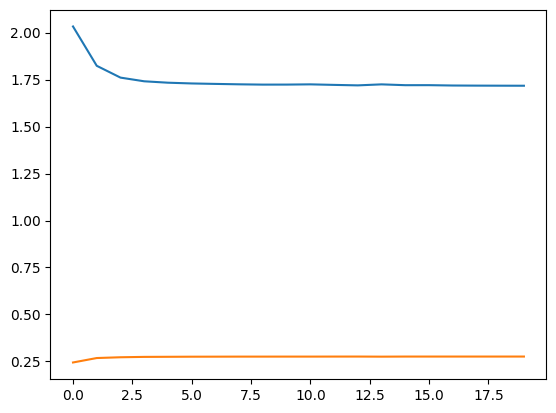

In [42]:
#plot results
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['accuracy'])

Training model 3 took almost double the time that the model with one LSTM layer (model_2) took. And we can see the performence is almost the matching.